In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('indices_df.xlsx')

training_df.head()

,DWSI,MSI,LWVI1,LWVI2,NDII,NDWI,WBI,NMDI,SD,SR,ND,MDATT,RWC
0,1.190506,0.566488,0.012489,0.043199,0.246819,0.051212,0.964867,0.476835,-0.0002,1.078975,0.088782,1.000000,98.373025
1,0.618247,0.613605,0.012485,0.033338,0.211824,0.041076,0.967167,0.464036,-0.0005,1.063830,0.174036,1.121212,99.923489
2,0.877961,0.599918,0.013940,0.040439,0.218082,0.042208,0.971235,0.462263,-0.0005,1.063927,0.053232,1.000000,96.795629
3,0.812883,0.574080,0.001007,0.038107,0.246667,0.062585,0.960879,0.493574,-0.0003,1.064880,0.101695,1.083333,94.518349
4,0.817941,0.594934,0.007980,0.037414,0.228148,0.051164,0.965721,0.470293,-0.0006,1.051447,0.055233,1.081967,95.493562


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['RWC'])
y = training_df['RWC']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 15:49:32,407] A new study created in memory with name: no-name-d2675b75-2dd8-4501-a111-a6b98f43619a
[I 2024-03-13 15:49:32,420] Trial 0 finished with value: 421.309205153022 and parameters: {'n_components': 12, 'max_iter': 518}. Best is trial 0 with value: 421.309205153022.
[I 2024-03-13 15:49:32,489] Trial 1 finished with value: 260.4690487507882 and parameters: {'n_components': 3, 'max_iter': 624}. Best is trial 1 with value: 260.4690487507882.
[I 2024-03-13 15:49:32,508] Trial 2 finished with value: 240.3171229413875 and parameters: {'n_components': 8, 'max_iter': 716}. Best is trial 2 with value: 240.3171229413875.
[I 2024-03-13 15:49:32,520] Trial 3 finished with value: 492.1733438957811 and parameters: {'n_components': 2, 'max_iter': 771}. Best is trial 2 with value: 240.3171229413875.
[I 2024-03-13 15:49:32,544] Trial 4 finished with value: 257.8937225344982 and parameters: {'n_components': 4, 'max_iter': 778}. Best is trial 2 with value: 240.3171229413875.
[I 2024

[I 2024-03-13 15:49:34,414] Trial 46 finished with value: 222.6536236964936 and parameters: {'n_components': 6, 'max_iter': 106}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:34,463] Trial 47 finished with value: 236.66862041507 and parameters: {'n_components': 5, 'max_iter': 153}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:34,507] Trial 48 finished with value: 240.3171229413875 and parameters: {'n_components': 8, 'max_iter': 681}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:34,551] Trial 49 finished with value: 268.3942938762044 and parameters: {'n_components': 7, 'max_iter': 733}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:34,604] Trial 50 finished with value: 319.69414577936203 and parameters: {'n_components': 10, 'max_iter': 823}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:34,651] Trial 51 finished with value: 222.6536236964936 and parameters: {'n_components': 6, 'ma

[I 2024-03-13 15:49:36,563] Trial 93 finished with value: 236.66862041507 and parameters: {'n_components': 5, 'max_iter': 203}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:36,606] Trial 94 finished with value: 222.6536236964936 and parameters: {'n_components': 6, 'max_iter': 168}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:36,655] Trial 95 finished with value: 268.3942938762044 and parameters: {'n_components': 7, 'max_iter': 222}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:36,698] Trial 96 finished with value: 222.6536236964936 and parameters: {'n_components': 6, 'max_iter': 131}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:36,736] Trial 97 finished with value: 236.66862041507 and parameters: {'n_components': 5, 'max_iter': 245}. Best is trial 6 with value: 222.6536236964936.
[I 2024-03-13 15:49:36,777] Trial 98 finished with value: 268.3942938762044 and parameters: {'n_components': 7, 'max_it

Number of finished trials:  100
Best trial:
  Value: 222.6536236964936
  Params: 
    n_components: 6
    max_iter: 968
Mean Squared Error: 222.6536236964936
Root Mean Squared Error: 14.921582479633104
R-Squared value: 0.7013229975784034


In [7]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
SR: 10.192192437052276
ND: -9.478628085261526
WBI: 7.780861961971238


# <font color = Blue> Elastic Net

In [8]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 15:52:05,413] A new study created in memory with name: no-name-b5af6dd0-43c5-447e-b5b5-6517fab0829a
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:05,423] Trial 0 finished with value: 362.2107273929675 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 362.2107273929675.
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:05,696] Trial 10 finished with value: 371.8385719667971 and parameters: {'alpha': 0.9792371219438649, 'l1_ratio': 0.33699809840130024, 'max_iter': 132}. Best is trial 8 with value: 245.11011428790542.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:06,078] Trial 20 finished with value: 341.29515965732617 and parameters: {'alpha': 0.4099917009035815, 'l1_ratio': 0.002987805394491838, 'max_iter': 271}. Best is trial 19 with value: 236.50968578060474.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecat

[I 2024-03-13 15:52:06,425] Trial 29 finished with value: 357.12143281004285 and parameters: {'alpha': 0.8899471780452569, 'l1_ratio': 0.4805734544344706, 'max_iter': 123}. Best is trial 28 with value: 232.8272119839114.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:06,473] Trial 30 finished with value: 266.00496254091865 and parameters: {'alpha': 0.6496692847761159, 'l1_ratio'

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:06,893] Trial 40 finished with value: 260.4076096327473 and parameters: {'alpha': 0.6731970754659242, 'l1_ratio': 0.927214940401854, 'max_iter': 310}. Best is trial 28 with value: 232.8272119839114.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in

[I 2024-03-13 15:52:07,340] Trial 49 finished with value: 251.52594545889667 and parameters: {'alpha': 0.7641708846538593, 'l1_ratio': 0.9550043766214331, 'max_iter': 201}. Best is trial 28 with value: 232.8272119839114.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:07,381] Trial 50 finished with value: 272.3372485958474 and parameters: {'alpha': 0.42762335482216773, 'l1_ratio'

[I 2024-03-13 15:52:07,770] Trial 59 finished with value: 290.6481513783945 and parameters: {'alpha': 0.5678813957574811, 'l1_ratio': 0.7950453910182487, 'max_iter': 459}. Best is trial 28 with value: 232.8272119839114.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:07,801] Trial 60 finished with value: 245.96510304580477 and parameters: {'alpha': 0.6213707488617408, 'l1_ratio':

[I 2024-03-13 15:52:08,184] Trial 69 finished with value: 282.60914828586374 and parameters: {'alpha': 0.5463632101056205, 'l1_ratio': 0.8273051017288262, 'max_iter': 122}. Best is trial 28 with value: 232.8272119839114.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:08,225] Trial 70 finished with value: 355.0151173305103 and parameters: {'alpha': 0.5811065999266584, 'l1_ratio':

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:08,694] Trial 80 finished with value: 244.78567347966344 and parameters: {'alpha': 0.46809391771878595, 'l1_ratio': 0.965409314724974, 'max_iter': 583}. Best is trial 75 with value: 232.12973030174294.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

[I 2024-03-13 15:52:09,086] Trial 89 finished with value: 252.31622390551163 and parameters: {'alpha': 0.5859005647324753, 'l1_ratio': 0.9460655274605702, 'max_iter': 156}. Best is trial 75 with value: 232.12973030174294.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-13 15:52:09,126] Trial 90 finished with value: 271.256550203795 and parameters: {'alpha': 0.6398500681160834, 'l1_ratio':

[I 2024-03-13 15:52:09,522] Trial 99 finished with value: 351.62341988907434 and parameters: {'alpha': 0.730181702141601, 'l1_ratio': 0.4031834558010373, 'max_iter': 220}. Best is trial 75 with value: 232.12973030174294.


Number of finished trials:  100
Best trial:
  Value: 232.12973030174294
  Params: 
    alpha: 0.7060546883857337
    l1_ratio: 0.9977123241243392
    max_iter: 134
Mean Squared Error: 232.12973030174294
Root Mean Squared Error: 15.235804222348847
R-Squared value: 0.6886113467707731


In [9]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
ND: -8.277157455766329
SR: 8.211207783715503
WBI: 3.2904759888807003


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [22]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 16:03:03,462] A new study created in memory with name: no-name-dfac931e-406d-4c0c-a789-2da905663739
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:03,475] Trial 0 finished with value: 592.4781675024813 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 592.4781675024813.
/var/folder

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:03,734] Trial 10 finished with value: 128.37593031624334 and parameters: {'alpha': 0.9822334069719648, 'gamma': 0.009819189785151882, 'kernel': 'rbf'}. Best is trial 10 with value: 128.37593031624334.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has bee

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:04,091] Trial 20 finished with value: 5315.652866139361 and parameters: {'alpha': 0.8834815516505645, 'gamma': 4.465628203392695, 'kernel': 'rbf'}. Best is trial 13 with value: 71.92769279992413.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been dep

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:04,356] Trial 29 finished with value: 1360.4410511909712 and parameters: {'alpha': 0.6822494152478036, 'gamma': 0.5846304792512553, 'kernel': 'rbf'}. Best is trial 13 with value: 71.92769279992413.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has bee

[I 2024-03-13 16:03:04,639] Trial 38 finished with value: 13617.573071751905 and parameters: {'alpha': 0.7403528685847822, 'gamma': 0.02296447108540857, 'kernel': 'linear'}. Best is trial 31 with value: 40.27622272688219.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:04,675] Trial 39 finished with value: 230.69841219506702 and parameters: {'alpha': 0.0456461023561

[I 2024-03-13 16:03:05,024] Trial 48 finished with value: 5330.408910986709 and parameters: {'alpha': 0.3096506585376336, 'gamma': 22.963781512258247, 'kernel': 'rbf'}. Best is trial 43 with value: 40.09887026554967.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:05,099] Trial 49 finished with value: 44.73081576077514 and parameters: {'alpha': 0.9421645551481699, '

[I 2024-03-13 16:03:05,377] Trial 58 finished with value: 13239.897846598335 and parameters: {'alpha': 0.9639557007880181, 'gamma': 0.0014148540004366304, 'kernel': 'linear'}. Best is trial 57 with value: 37.63776000261421.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:05,406] Trial 59 finished with value: 649.7750885552196 and parameters: {'alpha': 0.832257945690

[I 2024-03-13 16:03:05,703] Trial 68 finished with value: 1314.4527750418954 and parameters: {'alpha': 0.7852143689822381, 'gamma': 0.5577847965471266, 'kernel': 'rbf'}. Best is trial 57 with value: 37.63776000261421.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:05,725] Trial 69 finished with value: 45.95938855551914 and parameters: {'alpha': 0.7062070943922053, 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:06,010] Trial 78 finished with value: 437.9342192510088 and parameters: {'alpha': 0.6551515861200725, 'gamma': 0.35119916382462696, 'kernel': 'rbf'}. Best is trial 57 with value: 37.63776000261421.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has bee

[I 2024-03-13 16:03:06,401] Trial 87 finished with value: 13498.175953519412 and parameters: {'alpha': 0.8067724900974478, 'gamma': 0.9352985996639854, 'kernel': 'linear'}. Best is trial 57 with value: 37.63776000261421.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:06,440] Trial 88 finished with value: 275.6717645716727 and parameters: {'alpha': 0.875356352820463

[I 2024-03-13 16:03:06,787] Trial 97 finished with value: 1472.9284760875883 and parameters: {'alpha': 0.9775520155257293, 'gamma': 0.5577132161871635, 'kernel': 'rbf'}. Best is trial 96 with value: 37.52383475736953.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 16:03:06,821] Trial 98 finished with value: 818.7057607158437 and parameters: {'alpha': 0.9575446587183735, 

Number of finished trials:  100
Best trial:
  Value: 37.52383475736953
  Params: 
    alpha: 0.9772426548454272
    gamma: 0.02742557351146193
    kernel: rbf
Mean Squared Error: 37.52383475736953
Root Mean Squared Error: 6.1256701476140165
R-Squared value: 0.9496639385489105


In [23]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
LWVI1: 327.8728572076228
ND: 305.0158109972532
MSI: 167.32676608843997


In [24]:
# Add Gaussian Noise
noise_mean = 0
noise_std = 0.05  # Adjust the standard deviation for the Gaussian noise

# Generate Gaussian noise with the same shape as your input features
gaussian_noise_train = np.random.normal(noise_mean, noise_std, X_train.shape)
gaussian_noise_test = np.random.normal(noise_mean, noise_std, X_test.shape)

# Add the noise to the training and testing data
X_train_noisy = X_train + gaussian_noise_train
X_test_noisy = X_test + gaussian_noise_test

# Retrain the Model
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

best_krr.fit(X_train_noisy, y_train)

# Evaluate Changes in Predictions
# Predict on the noisy dataset
y_pred_noisy = best_krr.predict(X_test_noisy)

# Compute the average absolute difference in predictions
average_absolute_difference = np.mean(np.abs(y_pred - y_pred_noisy))
print(f"Average Absolute Difference in Predictions: {average_absolute_difference}")

Average Absolute Difference in Predictions: 0.4210206567585786


In [25]:
# Get the learned coefficients
coefficients = best_krr.dual_coef_

# Calculate the importance scores for each feature
feature_importances = np.abs(np.dot(coefficients, X_train_noisy))

# Normalize the feature importances
feature_importances /= np.sum(feature_importances)

# Get the names of the features
feature_names = X.columns 

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
WBI: 0.16908408738909636
SR: 0.15857169516193848
LWVI1: 0.1028297029722911


In [26]:
# Make predictions
y_pred = best_krr.predict(X_test_noisy)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 37.42314926654525
Root Mean Squared Error: 6.117446302710409
R-Squared value: 0.9497990023313341


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 3


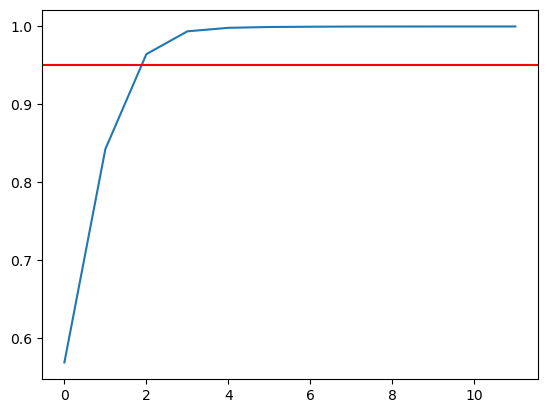

In [12]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [13]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 530.4237668168148
Root Mean Squared Error: 23.03093065459611
R-Squared value: 0.28846709047065444


In [14]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
LWVI1: 0.43893742263301266
DWSI: 0.3927598577444286
ND: 0.3490474451710348


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [15]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 15:54:26,046] A new study created in memory with name: no-name-62765781-e1a0-406d-b4ad-29f7be4ab6d0
[I 2024-03-13 15:54:26,348] Trial 0 finished with value: 494.88119858220415 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 494.88119858220415.
[I 2024-03-13 15:54:26,509] Trial 1 finished with value: 583.9251866263229 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 494.88119858220415.
[I 2024-03-13 15:54:26,625] Trial 2 finished with value: 582.8547018533525 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 494.88119858220415.
[I 2024-03-13 15:54:26,782] Trial 3 finished with value: 308.6950482045741 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 3

[I 2024-03-13 15:54:33,389] Trial 36 finished with value: 291.43043602255045 and parameters: {'n_estimators': 106, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 31 with value: 255.63763655391898.
[I 2024-03-13 15:54:33,526] Trial 37 finished with value: 590.5994223600504 and parameters: {'n_estimators': 81, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 31 with value: 255.63763655391898.
[I 2024-03-13 15:54:33,737] Trial 38 finished with value: 323.99000467914743 and parameters: {'n_estimators': 126, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 31 with value: 255.63763655391898.
[I 2024-03-13 15:54:33,932] Trial 39 finished with value: 339.15170929758926 and parameters: {'n_estimators': 114, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 31 with value: 255.63763655391898.
[I 2024-03-13 15:54:34,136] Trial 40 finished with value: 456.51803664802424 and paramet

[I 2024-03-13 15:54:40,633] Trial 72 finished with value: 268.0366164854494 and parameters: {'n_estimators': 117, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 65 with value: 251.84908005722275.
[I 2024-03-13 15:54:40,823] Trial 73 finished with value: 328.7438964996617 and parameters: {'n_estimators': 120, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 65 with value: 251.84908005722275.
[I 2024-03-13 15:54:41,025] Trial 74 finished with value: 295.2488297176267 and parameters: {'n_estimators': 128, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 65 with value: 251.84908005722275.
[I 2024-03-13 15:54:41,199] Trial 75 finished with value: 487.6390637035705 and parameters: {'n_estimators': 112, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 65 with value: 251.84908005722275.
[I 2024-03-13 15:54:41,354] Trial 76 finished with value: 295.4948169581029 and paramete

Best trial:
  Value: 250.94164628352885
  Params: 
    n_estimators: 135
    max_depth: 26
    min_samples_split: 3
    min_samples_leaf: 1
Mean Squared Error: 265.6955795828626
Root Mean Squared Error: 16.30017115194999
R-Squared value: 0.6435846946975701


In [16]:
# Get feature importances from the trained RandomForestRegressor model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
ND: 0.3884884507367923
SR: 0.16937091670216423
SD: 0.15475489717286736


## <font color = darkgreen> Gradient Boosting Regression

In [17]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-03-13 15:55:49,849] A new study created in memory with name: no-name-2be0ebc7-dc8a-4bd3-ace3-36b0d5fc0496
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:50,129] Trial 0 finished with value: 276.7643153592931 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 276.7643153592931.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugges

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:52,396] Trial 14 finished with value: 319.8720958535566 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.07849341548804481}. Best is trial 13 with value: 203.32116975018857.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:52,540] Trial 15 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:54,377] Trial 28 finished with value: 212.7817197465872 and parameters: {'n_estimators': 95, 'max_depth': 6, 'learning_rate': 0.09621245330518594}. Best is trial 25 with value: 191.41157553076886.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:54,544] Trial 29 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:56,211] Trial 42 finished with value: 295.93615600527016 and parameters: {'n_estimators': 127, 'max_depth': 9, 'learning_rate': 0.020297693810864288}. Best is trial 25 with value: 191.41157553076886.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:56,356] Trial 43

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:57,709] Trial 56 finished with value: 223.85581417133434 and parameters: {'n_estimators': 55, 'max_depth': 8, 'learning_rate': 0.09101059337581863}. Best is trial 25 with value: 191.41157553076886.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:57,797] Trial 57 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:59,094] Trial 70 finished with value: 202.6809677544583 and parameters: {'n_estimators': 65, 'max_depth': 8, 'learning_rate': 0.08260458954390042}. Best is trial 25 with value: 191.41157553076886.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:55:59,182] Trial 71 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:56:00,776] Trial 84 finished with value: 268.66171671408813 and parameters: {'n_estimators': 107, 'max_depth': 7, 'learning_rate': 0.07275785571668637}. Best is trial 25 with value: 191.41157553076886.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:56:00,898] Trial 85 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:56:02,880] Trial 98 finished with value: 193.8670552124346 and parameters: {'n_estimators': 99, 'max_depth': 8, 'learning_rate': 0.09387495457442935}. Best is trial 93 with value: 187.00503345642545.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 15:56:03,024] Trial 99 fi

Best trial:
  Value: 187.00503345642545
  Params: 
    n_estimators: 95
    max_depth: 8
    learning_rate: 0.09020238812716573
Mean Squared Error: 192.5547746337172
Root Mean Squared Error: 13.8764107258944
R-Squared value: 0.7416988686967846


In [18]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
ND: 0.6092878540301923
NMDI: 0.15801443023645806
LWVI1: 0.08338130651364013


## <font color = green> XGBoost

In [19]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 15:56:40,420] A new study created in memory with name: no-name-dc1695d3-0b27-4c30-b0a8-9ced83f8a9a2
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-03-13 15:56:41,317] Trial 6 finished with value: 425.5211570620213 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 4 with value: 355.0313939883648.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-03-13 15:56:43,618] Trial 26 finished with value: 282.92687032278775 and parameters: {'n_estimators': 82, 'max_depth': 7, 'learning_rate': 0.055882840601183155, 'min_child_weight': 2, 'subsample': 0.8461139197190132, 'colsample_bytree': 0.7064956020293299}. Best is trial 10 with value: 280.62525291903677.
/var/folders/3h

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-13 15:56:45,132] Trial 39 finished with value: 256.9367921799766 and parameters: {'n_estimators': 132, 'max_depth': 6, 'learning_rate': 0.08651658440371537, 'min_child_weight': 3, 'subsample': 0.8871404640802605, 'colsample_bytree': 0.7740985392125435}. Best is trial 34 with value: 254.17161368805395.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-13 15:56:47,009] Trial 52 finished with value: 190.5695977835353 and parameters: {'n_estimators': 135, 'max_depth': 4, 'learning_rate': 0.09123784988468153, 'min_child_weight': 1, 'subsample': 0.9419997034891171, 'colsample_bytree': 0.9487294400622417}. Best is trial 52 with value: 190.5695977835353.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-13 15:56:48,624] Trial 65 finished with value: 187.36512045796604 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.09333224471949514, 'min_child_weight': 1, 'subsample': 0.9997311732335167, 'colsample_bytree': 0.9317199056627534}. Best is trial 63 with value: 166.50629389967492.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-13 15:56:50,260] Trial 78 finished with value: 208.24060519384437 and parameters: {'n_estimators': 129, 'max_depth': 4, 'learning_rate': 0.0888685399251226, 'min_child_weight': 2, 'subsample': 0.9541614966060001, 'colsample_bytree': 0.9014984254201829}. Best is trial 67 with value: 162.21035568369575.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-13 15:56:53,006] Trial 98 finished with value: 221.90884740765142 and parameters: {'n_estimators': 148, 'max_depth': 3, 'learning_rate': 0.07334183883000839, 'min_child_weight': 1, 'subsample': 0.987085784284127, 'colsample_bytree': 0.8775393231555039}. Best is trial 67 with value: 162.21035568369575.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_12336/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

Best trial:
  Value: 162.21035568369575
  Params: 
    n_estimators: 139
    max_depth: 4
    learning_rate: 0.07904495394558252
    min_child_weight: 1
    subsample: 0.9952812750734144
    colsample_bytree: 0.9265096444691592
Mean Squared Error: 162.21035568369575
Root Mean Squared Error: 12.736182932248411
R-Squared value: 0.7824041576642429


In [20]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
ND: 0.29127565026283264
SR: 0.2794704735279083
NMDI: 0.23356179893016815
